<a href="https://colab.research.google.com/github/Developer-AD/Yes_Bank_Price_Prediction/blob/main/Yes_Bank_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**Capstone Project 2 - Yes Bank Stock Price Prediction**

##**(Supervised - Regression Machine Learning Model)**

##**Project by:- Abhishek Kumar**

##**Data Science Trainee at AlmaBetter**

#<b>Problem Statement </b>
### <b>Yes Bank is a well-known bank in the Indian financial domain. Since 2018, it has been in the news because of the fraud case involving Rana Kapoor. Owing to this fact, it was interesting to see how that impacted the stock prices of the company and whether Time series models or any other predictive models can do justice to such situations. This dataset has monthly stock prices of the bank since its inception and includes closing, starting, highest, and lowest stock prices of every month. The main objective is to predict the stock’s closing price of the month.</b>

# <b>Bussiness Goal :</b>
###<b>The main objective is to predict the stock's closing price of the month.To determine the YES bank's stock’s future value on the national stock exchange. The advantage of a successful prediction of a stock's future price could results insignificant profit. The efficient-market hypothesis recommends that stock costs mirror all right now accessible data and any value changes that are not founded on recently uncovered data subsequently are an unpredictable.We have to build model which help us to predict the future stock prices.</b>

#<b>What is Stock Market ?<b>

###<b>A stock market, equity market, or share market is the aggregation of buyers and sellers of stocks (shares), which represent ownership claims on businesses. These may include securities listed on a public stock exchange, as well as stock that is only traded privately, such as shares of private companies which are sold to investors through equity crowdfunding platforms. Investment is usually made with an investment strategy in mind. Image ------------------------></b>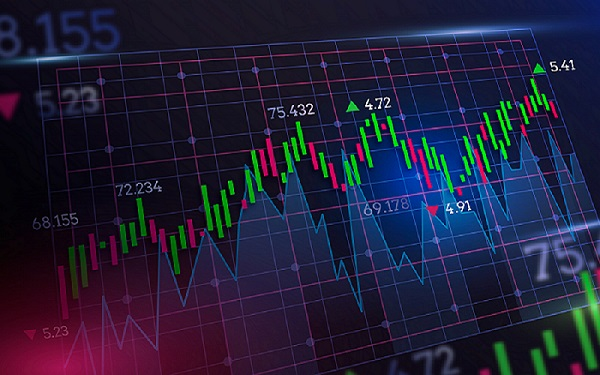

#<b>What is Stocks ?

##<b> A stock is a general term used to describe the ownership certificates of any company. A share, on the other hand, refers to the stock certificate of a particular company. Holding a particular company's share makes you a shareholder.

#<b>Some Information About Yes Bank :- </b>

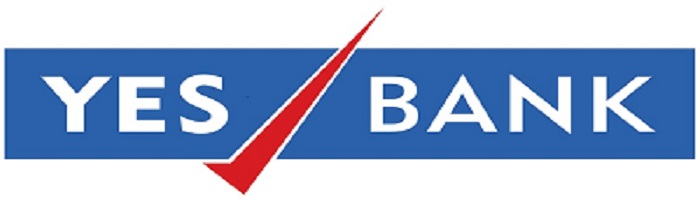
###<b>Yes Bank is an Indian bank headquartered in Mumbai, India and was founded by Rana Kapoor and Ashok Kapoor in 2004. It offers wide range of differentiated products for corporate and retail customers through retail banking and asset management services.On 5 March 2020, in an attempt to avoid the collapse of the bank, which had an excessive amount of bad loans, the Reserve Bank of India (RBI) took control of it. RBI later reconstructed the board and named Prashant Kumar, former chief financial officer and deputy managing director of State Bank of India, as MD & CEO of Yes Bank, along with Sunil Mehta, former non-executive chairman of Punjab National Bank, as Yes Bank's non-executive chairman.</b>

# <b>Steps to solve this problem :

###<b> 1. Load the dataset
###<b> 2. Exploratory Data Analysis On Data
###<b> 3. Preprocess the data
###<b> 4. Build machine learning model.
###<b> 5. Conclusion.

# <b> Import Important Libraries </b>

In [1]:
# Data Wrangling Libraries
import numpy as np
import pandas as pd

# Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine Learning Libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Remove Warnings.
import warnings
warnings.filterwarnings('ignore')

# <b>Exploratory Data Analysis</b>

In [2]:
# Mouting the drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


###<b>Loading the yes bank dataset</b>

In [3]:
# Load csv file as data frame
csv_file_path = '/content/drive/MyDrive/AlmaBetter/CapstoneProject/Yes_Bank_Price_Prediction/data_YesBank_StockPrices.csv'
yes_bank = pd.read_csv(csv_file_path)

In [4]:
# Take quick look at the data structure
yes_bank.head()

,Date,Open,High,Low,Close
0,Jul-05,13.00,14.00,11.25,12.46
1,Aug-05,12.58,14.88,12.55,13.42
2,Sep-05,13.48,14.87,12.27,13.30
3,Oct-05,13.20,14.47,12.40,12.99
4,Nov-05,13.35,13.88,12.88,13.41


##<b>Yes Bank Dateset All Features Information</b>
### <b>Open = Price at stock started trading when the market open on the particular day.
### <b>High = Highest stock price during a period
### <b>Low = lowest stock price during a period
### <b>Date = month of year stock price
### <b>Close = Price of an indivisual stock when the stock exchange close the market of the day(Taget/dependent variable)

In [6]:
# Check shape of the data
yes_bank.shape

(185, 5)

In [7]:
# Check for duplicate record
yes_bank[yes_bank.duplicated()]

,Date,Open,High,Low,Close


###<b>As we can conclude that there is no duplicate record are present

###<b>A quick description of the data like how many non-null values are present in our data, it means we can also find null values from this non-null values, Data type of the feature and Total number of records</b>

In [8]:
# A quick description of the data
yes_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB


###<b>As we can see that there is one 'object' data type are present that we need to convert in numerical data types because we can not process object data type to fit in the machine learning model. In machine learning model we can only fit numerical column.</b>

In [9]:
# Check for null values
yes_bank.isnull().sum()

Date     0
Open     0
High     0
Low      0
Close    0
dtype: int64

###<b>We can conclude that there is no null values are present that's good. We can good to go.</b>

In [10]:
# Summary of the Numerical features
yes_bank.describe()

,Open,High,Low,Close
count,185.000000,185.000000,185.000000,185.000000
mean,105.541405,116.104324,94.947838,105.204703
std,98.879850,106.333497,91.219415,98.583153
min,10.000000,11.240000,5.550000,9.980000
25%,33.800000,36.140000,28.510000,33.450000
50%,62.980000,72.550000,58.000000,62.540000
75%,153.000000,169.190000,138.350000,153.300000
max,369.950000,404.000000,345.500000,367.900000


In [11]:
# Summary of the Categorical features
yes_bank.describe(include='object')

,Date
count,185
unique,185
top,Jul-05
freq,1


#<b>Visualization of Yes Bank Datasets</b>

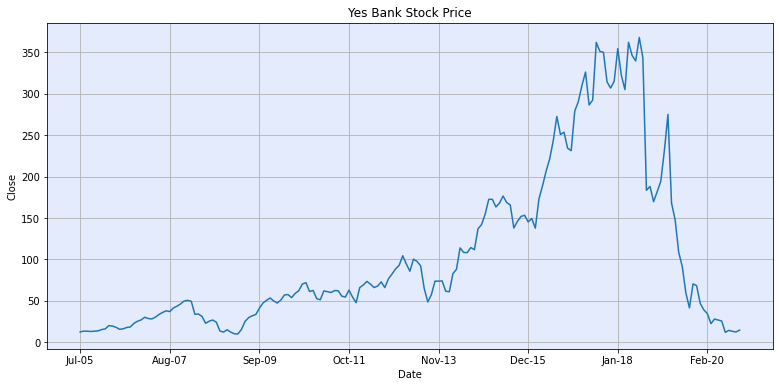

In [12]:
# Visualize the Closing Price
plt.figure(figsize=(13,6))
ax = yes_bank[['Date','Close']]
ax = ax.set_index('Date')
ax['Close'].plot()
plt.axes().set_facecolor("#e3ebfc")
plt.title('Yes Bank Stock Price')
plt.ylabel('Close')
plt.grid()
plt.show()

###<b>Plot Histogram For Dependent Variable Close</b>

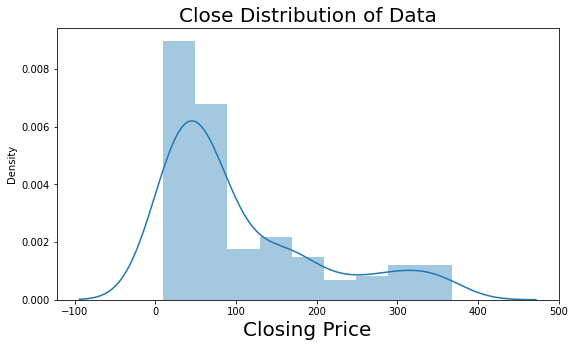

In [13]:
# Dependent variable 'Closing price'
plt.figure(figsize=(9, 5))
sns.distplot(yes_bank['Close'])
plt.title('Close Distribution of Data', fontsize = 20)
plt.xlabel('Closing Price', fontsize = 20)
plt.show()

###<b>We can see that the distribution of dependent variable is right skewed distribution, the skewed distribution make difficult for machine learning model to learn patter of the data. So we need to use transformation to make the data normally distributed.

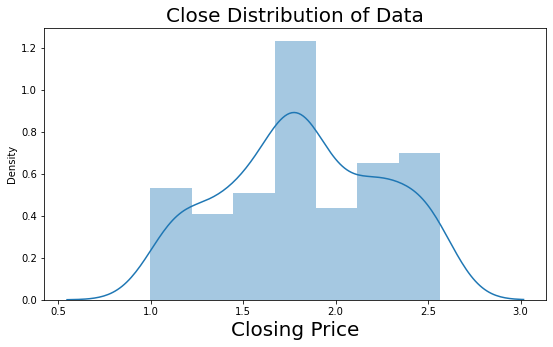

In [14]:
# Applying log transformation and plot the distribution of dependent variable 'Close'
plt.figure(figsize=(9, 5))
sns.distplot(np.log10( yes_bank['Close']) )
plt.title('Close Distribution of Data', fontsize = 20)
plt.xlabel('Closing Price', fontsize = 20)
plt.show()


In [15]:
# List of numeric features for plot the relationship
numeric_features = yes_bank.describe().columns
numeric_features

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

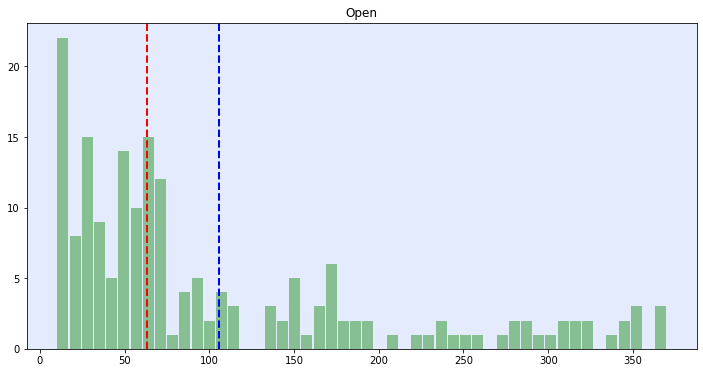

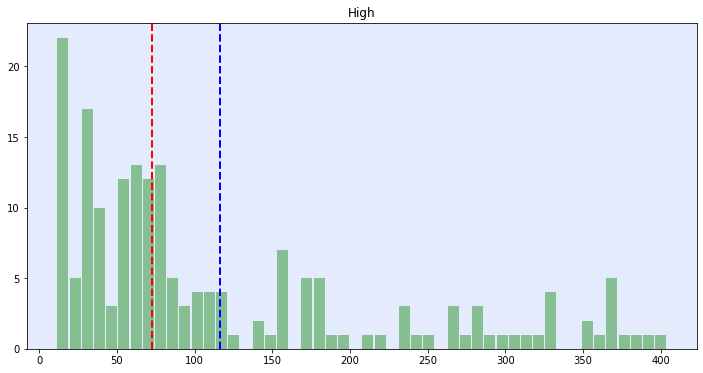

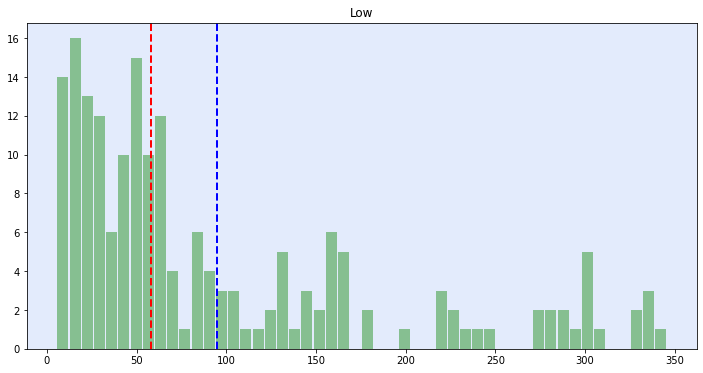

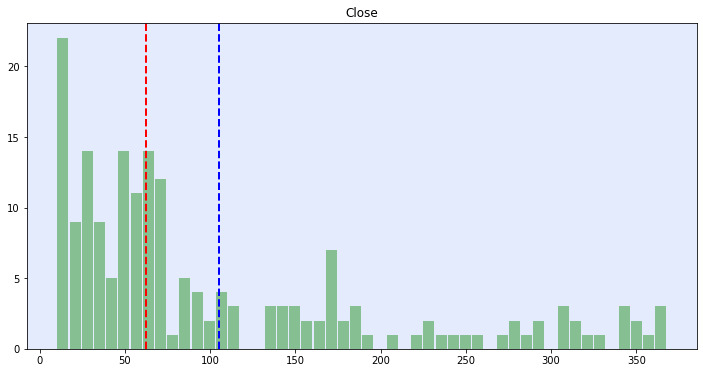

In [16]:
# Plot all features.
# plot a bar plot for each numerical feature count (except Date)

for col in numeric_features:
    fig = plt.figure(figsize=(12, 6))
    ax = fig.gca()
    feature = yes_bank[col]
    feature.hist(bins=50, ax = ax , grid=False, color='#86bf91', zorder=2, rwidth=0.9)
    ax.axvline(feature.mean(), color='blue', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='red', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
    plt.axes().set_facecolor("#e3ebfc")
plt.show()

###<b>Check correlation between all independent and dependent variable</b>

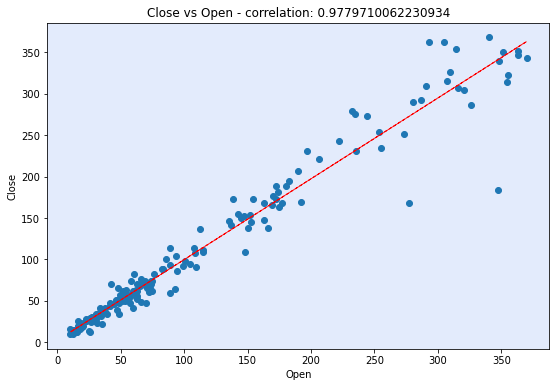

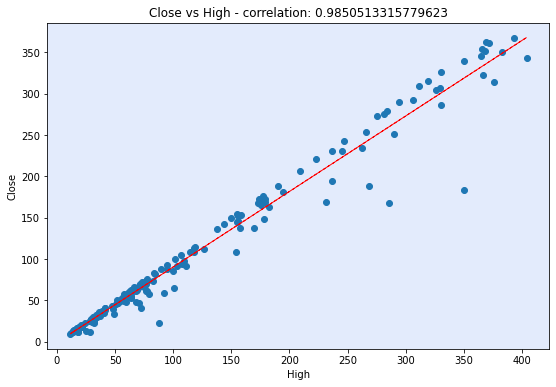

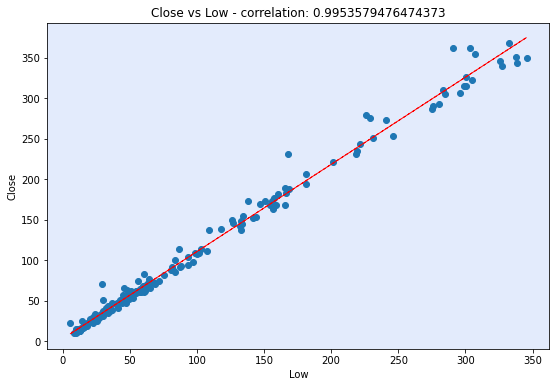

In [17]:
# Removed close for check correlation
for col in numeric_features[:-1]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = yes_bank[col]
    label = yes_bank['Close']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Close')
    ax.set_title('Close vs ' + col + ' - correlation: ' + str(correlation))
    z = np.polyfit(yes_bank[col], yes_bank['Close'], 1)
    y_hat = np.poly1d(z)(yes_bank[col])
    plt.axes().set_facecolor("#e3ebfc")

    plt.plot(yes_bank[col], y_hat, "r--", lw=1)
plt.show()

###<b> Check Correlation between all features using seaborn Heatmap

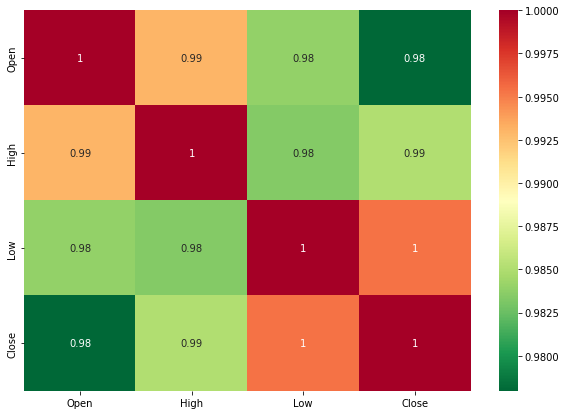

In [18]:
# Plot Correlation headtmap graph using seaborn
plt.figure(figsize=(10,7))
correlation = yes_bank.corr()
sns.heatmap(abs(correlation), annot=True, cmap = 'RdYlGn_r')
plt.show()

###<b>Check for Multicollinearity

In [19]:
#Check for Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)


In [20]:
calc_vif(yes_bank[[i for i in yes_bank.describe().columns if i not in ['Date','Close']]])

,variables,VIF
0,Open,175.185704
1,High,167.057523
2,Low,71.574137


##<b> Feature Engineering On Date Column</b>

In [21]:
# Check data type of 'Date' column
print( yes_bank.Date.dtype )

object


###<b>Here we can see that our Date column is 'object' type from object we can not extract year and month so, we have to convert this object date type to pandas 'datetime64[ns]' so we can apply some functions on it and extract desired year, month, day etc from it</b>

In [22]:
# Convert Date column from object type to pandas datetime64[ns]
yes_bank['Date'] = pd.to_datetime(yes_bank['Date'], format='%b-%y')

In [23]:
# Check change on Date column
yes_bank.head()

,Date,Open,High,Low,Close
0,2005-07-01,13.00,14.00,11.25,12.46
1,2005-08-01,12.58,14.88,12.55,13.42
2,2005-09-01,13.48,14.87,12.27,13.30
3,2005-10-01,13.20,14.47,12.40,12.99
4,2005-11-01,13.35,13.88,12.88,13.41


In [24]:
# Date type of Date column
# Date column changed from boject type to pandas datetime64[ns]
# Now we can apply functions on this column
print(yes_bank.Date.dtype)

datetime64[ns]


In [25]:
# Extract year from Date column
yes_bank['Year'] = yes_bank['Date'].dt.year

In [26]:
# Extract Month from Date column
yes_bank['Month'] = yes_bank['Date'].dt.month

In [27]:
# Check change after new column added
yes_bank.head()

,Date,Open,High,Low,Close,Year,Month
0,2005-07-01,13.00,14.00,11.25,12.46,2005,7
1,2005-08-01,12.58,14.88,12.55,13.42,2005,8
2,2005-09-01,13.48,14.87,12.27,13.30,2005,9
3,2005-10-01,13.20,14.47,12.40,12.99,2005,10
4,2005-11-01,13.35,13.88,12.88,13.41,2005,11


In [28]:
# Now we can drop the Date column
yes_bank.drop(columns = 'Date',inplace=True)

In [29]:
# Check for all column date type
yes_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    185 non-null    float64
 1   High    185 non-null    float64
 2   Low     185 non-null    float64
 3   Close   185 non-null    float64
 4   Year    185 non-null    int64  
 5   Month   185 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 8.8 KB


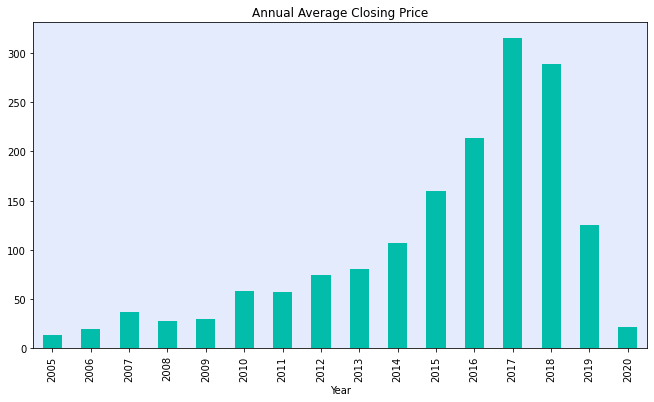

In [30]:
# Annual Average Closing Price.
yes_bank.groupby(['Year'])['Close'].mean().plot(kind='bar', figsize=(11,6), color='#02bdaa' )
plt.axes().set_facecolor("#e3ebfc")
plt.title('Annual Average Closing Price')
plt.show()

###<b> Box Plot visualization</b>

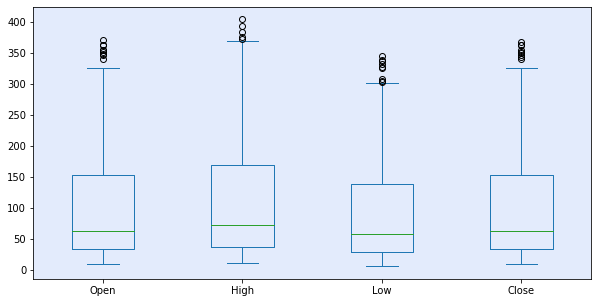

In [31]:
# Check for outliers
yes_bank[['Open', 'High', 'Low', 'Close']].plot(kind='box',figsize=(10,5))
plt.axes().set_facecolor("#e3ebfc")
plt.show()

###<b>Now our all feature are numerical and we can move to building our supervied machine learning model.</b>

#<b>Building Machine Learning Model</b>

In [32]:
# Differenciate Independent and Dependent variable
X = yes_bank.drop(columns='Close').values
y = yes_bank['Close'].values

In [33]:
# Check shape of dependent and independent variable
X.shape, y.shape

((185, 5), (185,))

In [34]:
# Split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

##<b>Rescalling the data</b>

In [35]:
# scale = StandardScaler()
'''Here we use MinMaxScaler but you can use StandardScale also,
   both are giving same accuracy. '''

# Resclalling data : this will rescale in between 0 and 1
scale = MinMaxScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

##<b>Linear Regression Model Trainning.</b>

In [36]:
# creating object of LinearRegression()
regressor = LinearRegression()

# Fitting data into Multiple linear regression
regressor.fit(x_train, y_train)

LinearRegression()

In [37]:
# Y intercept of regressor
regressor.intercept_

10.995140666464891

In [38]:
# Coefficients of regressor
regressor.coef_

array([-154.7127103 ,  177.78608317,  343.27674963,   -0.88664802,
         -4.30510043])

##<b>Checking Performance Of Regression Model</b>

In [39]:
# Do prediction on trainning data
y_pred_train = regressor.predict(x_train)

# Do prediction on test data
y_pred_test = regressor.predict(x_test)

###<b>Training Performance</b>

In [40]:
# Mean Absolute Error Of Trainning Data
MAE_train = mean_absolute_error(y_train, y_pred_train)
print(f"Mean Absolute Error On Trainning Data : {MAE_train}")

# Mean Squared Error Of Trainning Data
MSE_train = mean_squared_error(y_train, y_pred_train)
print(f"Mean Squared Error On Trainning Data : {MSE_train}")

# Root Mean Squared Error Of Trainning Data
# MSE**0.5 mean square root of MSE, you can use sqrt() from math module
RMSE_train = MSE_train**0.5 
print(f"Root Mean Squared Error On Trainning Data : {RMSE_train}")


Mean Absolute Error On Trainning Data : 4.020951233984054
Mean Squared Error On Trainning Data : 39.33625737830814
Root Mean Squared Error On Trainning Data : 6.271862353265427


In [41]:
# Check Accuracy of our on trainning data
# You can also use regressor.score(x_train, y_train) to check accuracy
r2_score_train = r2_score(y_train, y_pred_train)
print(f'R2 Score For Trainning Data : {r2_score_train}')

# adjusted R-squared for trainning data
adj_r2_score_train = 1 - ( ( 1- regressor.score(x_train, y_train) ) * ( len(y_train) - 1 ) / ( len(y_train) - x_train.shape[1] - 1 ) )
print(f"Adjusted R2 Score For Trainning Data : {adj_r2_score_train}")

R2 Score For Trainning Data : 0.9956465282860846
Adjusted R2 Score For Trainning Data : 0.9954932370285523


###<b>Testing Performance</b>

In [42]:
# Mean Absolute Error Of Testing Data
MAE_test = mean_absolute_error(y_train, y_pred_train)
print(f"Mean Absolute Error On Testing Data : {MAE_test}")

# Mean Squared Error Of Trainning Data
MSE_test = mean_squared_error(y_test, y_pred_test)
print(f"Mean Squared Error On Testing Data : {MSE_test}")

# Root Mean Squared Error Of Trainning Data
RMSE_test = MSE_test**0.5 
print(f"Root Mean Squared Error On Testing Data : {RMSE_test}")

Mean Absolute Error On Testing Data : 4.020951233984054
Mean Squared Error On Testing Data : 80.56653535374932
Root Mean Squared Error On Testing Data : 8.975886326917767


In [43]:
# Check Accuracy of our on test data
r2_score_test = r2_score(y_test, y_pred_test)
print(f'R2 Score For Testing Data : {r2_score_test}')

# adjusted R-squared
adj_r2_score_test = 1 - ( ( 1- regressor.score(x_test, y_test) ) * ( len(y_test) - 1 ) / ( len(y_test) - x_test.shape[1] - 1 ) )
print(f"Adjusted R2 Score for Testing Data : {adj_r2_score_test}")

R2 Score For Testing Data : 0.9928422855965229
Adjusted R2 Score for Testing Data : 0.9916878155314459


###<b>Conclusion : Now we can see that R2-Squared and Adjested R2-Squared has good score so we can say that our model is very good. Here we put all features which are important to build our regression model.<b>

###<b>Plotting the Actual and Predicted Prices for Yes Bank Stocks Closing Price.</b>

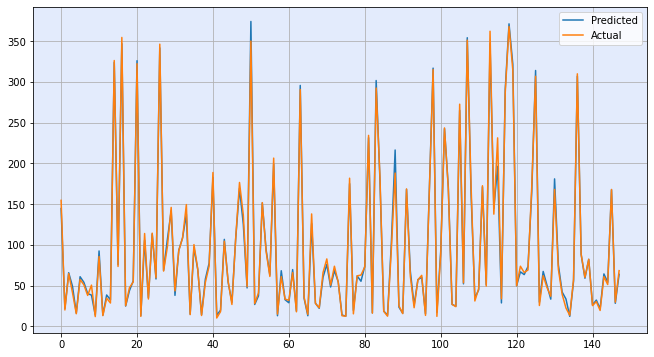

In [44]:
# On Trainning data
plt.figure( figsize=(11,6) )
plt.plot(y_pred_train, label='Predicted')
plt.plot( y_train, label='Actual')
plt.grid()
plt.axes().set_facecolor("#e3ebfc")
plt.legend()
plt.show()

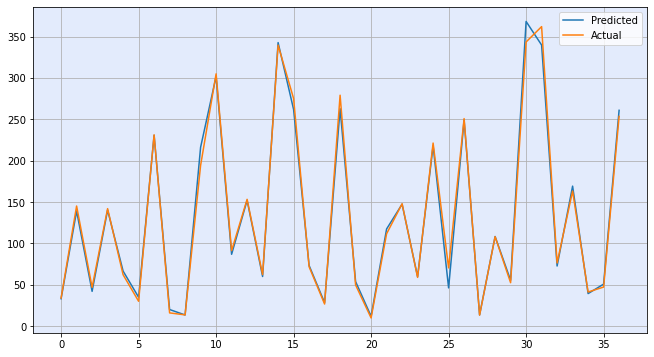

In [45]:
# On Testing data
plt.figure( figsize=(11,6) )
plt.plot(y_pred_test, label='Predicted')
plt.plot( y_test, label='Actual')
plt.axes().set_facecolor("#e3ebfc")
plt.grid()
plt.legend()
plt.show()

##<b>Regulerization On Linear Regression Model</b>

###<b>Ridge Regulerization</b>

In [46]:
# Finding best alpha value using GridseachCV hyperprarameter tuning
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60,
                                   100]},
             scoring='neg_mean_squared_error')

In [47]:
# print best alpha value
print(ridge_regressor.best_params_)

{'alpha': 0.01}


In [102]:
# Fitting the model with best parameter
ridge_with_best_alpha = Ridge(alpha=0.01)
ridge_with_best_alpha.fit(x_train, y_train)

Ridge(alpha=0.01)

In [103]:
# Ridge predicted values for trainning data
ridge_train = ridge_with_best_alpha.predict(x_train)

In [109]:
# Ridge predicted values for testing data
ridge_test = ridge_with_best_alpha.predict(x_test)

In [110]:
# Ridge regulerization accuracy score
ridge_accuracy = ridge_with_best_alpha.score(x_train, y_train)
ridge_accuracy

0.9955791667807274

In [111]:
# Ridge regulerization accuracy score on testing dataset
ridge_with_best_alpha.score(x_test, y_test)

0.9923741795879824

###<b>Plotting the Actual and Predicted Price For Ridge Trainning Data</b>

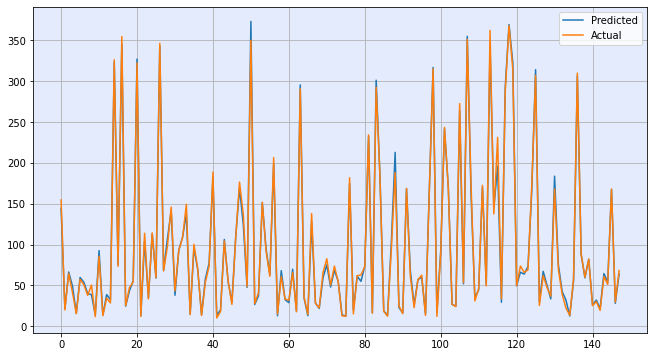

In [112]:
# On Trainning data
plt.figure( figsize=(11,6) )
plt.plot(ridge_train, label='Predicted')
plt.plot( y_train, label='Actual')
plt.grid()
plt.axes().set_facecolor("#e3ebfc")
plt.legend()
plt.show()

###<b>Plotting the Actual and Predicted Price For Ridge Testing Data</b>

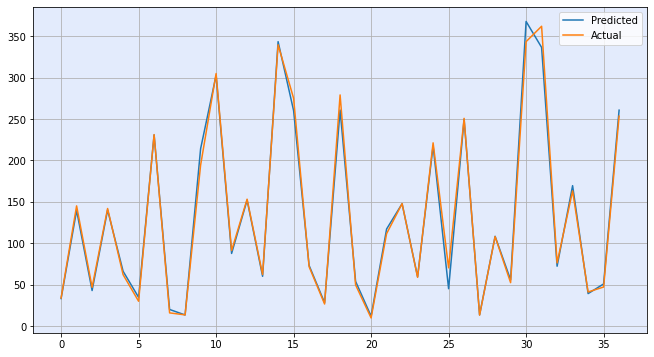

In [113]:
# On Testing data
plt.figure( figsize=(11,6) )
plt.plot(ridge_test, label='Predicted')
plt.plot( y_test, label='Actual')
plt.axes().set_facecolor("#e3ebfc")
plt.grid()
plt.legend()
plt.show()

###<b>Lasso Regulerization</b>

In [51]:
# Finding best alpha value using GridseachCV hyperprarameter tuning for Lasso regulerization
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60,
                                   100]},
             scoring='neg_mean_squared_error')

In [52]:
# best alpha value
print(lasso_regressor.best_params_)

{'alpha': 1e-08}


In [53]:
# Fitting the model with best parameter
lasso_with_best_alpha = Lasso(alpha=1e-08)
lasso_with_best_alpha.fit(x_train, y_train)

Lasso(alpha=1e-08)

In [54]:
# Lasso regulerization accuracy score on trainning dataset
lasso_with_best_alpha.score(x_train, y_train)

0.9956465282860844

In [55]:
# Lasso regulerization accuracy score on testing dataset
lasso_with_best_alpha.score(x_test, y_test)

0.9928422847792817

In [114]:
# Lasso predicted values for trainning data
lasso_train = lasso_with_best_alpha.predict(x_train)

In [115]:
# Lasso predicted values for testing data
lasso_test = lasso_with_best_alpha.predict(x_test)

###<b>Plotting the Actual and Predicted Price For Lasso Training Data</b>

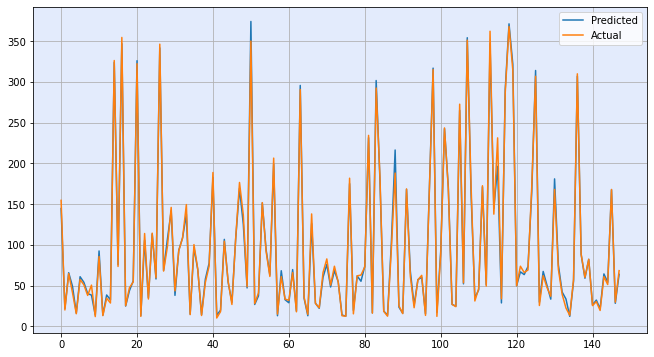

In [116]:
# On Trainning data
plt.figure( figsize=(11,6) )
plt.plot(lasso_train, label='Predicted')
plt.plot( y_train, label='Actual')
plt.grid()
plt.axes().set_facecolor("#e3ebfc")
plt.legend()
plt.show()

###<b>Plotting the Actual and Predicted Price For Lasso Testing Data</b>

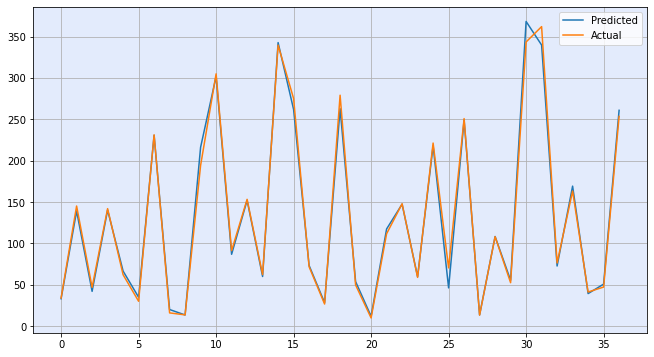

In [117]:
# On Testing data
plt.figure( figsize=(11,6) )
plt.plot(lasso_test, label='Predicted')
plt.plot( y_test, label='Actual')
plt.axes().set_facecolor("#e3ebfc")
plt.grid()
plt.legend()
plt.show()

##<b>Elastic Net Regulerization </b>

In [56]:
# Use grid search to tune the parameters for Elastic Net
eNet = ElasticNet()
parametersGrid = {
                  "max_iter": [1, 5, 10],
                  "alpha": [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100],
                  "l1_ratio": np.arange(0.0, 1.0, 0.1)
                  }

eNet_grid = GridSearchCV(eNet, parametersGrid, scoring='accuracy', cv=10)
eNet_grid.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=ElasticNet(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60,
                                   100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_iter': [1, 5, 10]},
             scoring='accuracy')

In [57]:
# best alpha value
eNet_grid.best_params_

{'alpha': 1e-15, 'l1_ratio': 0.0, 'max_iter': 1}

In [119]:
# Fitting the model with best parameter
elastic_reg_best = ElasticNet(alpha = 1e-15, l1_ratio = 0.0, max_iter = 1)
elastic_reg.fit(x_train, y_train)

ElasticNet(alpha=1e-15, l1_ratio=0.0, max_iter=1)

In [120]:
# ElasticNet regulerization accuracy score on trainning dataset
elastic_reg_best.score(x_train, y_train)

0.9543107874317996

In [139]:
# ElasticNet regulerization accuracy score on trainning dataset
elastic_reg_best.score(x_test, y_test)

0.96893394095658

In [122]:
# ElasticNet predicted values for trainnin data
elastic_train = elastic_reg_best.predict(x_train)

In [123]:
# ElasticNet predicted values for testing data
elastic_test = elastic_reg_best.predict(x_test)

###<b>Plotting the Actual and Predicted Price For ElasticNet Training Data</b>

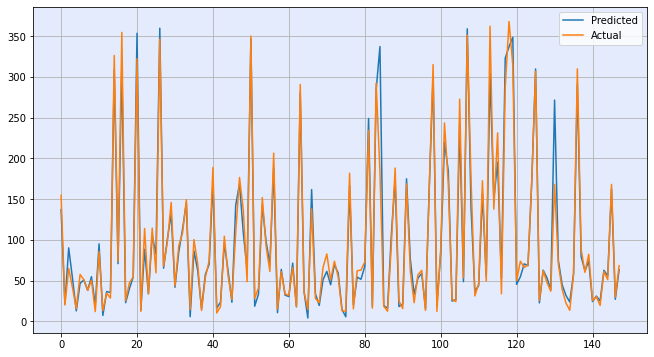

In [124]:
# On Trainning data
plt.figure( figsize=(11,6) )
plt.plot(elastic_train, label='Predicted')
plt.plot( y_train, label='Actual')
plt.grid()
plt.axes().set_facecolor("#e3ebfc")
plt.legend()
plt.show()

###<b>Plotting the Actual and Predicted Price For ElasticNet Testing Data</b>

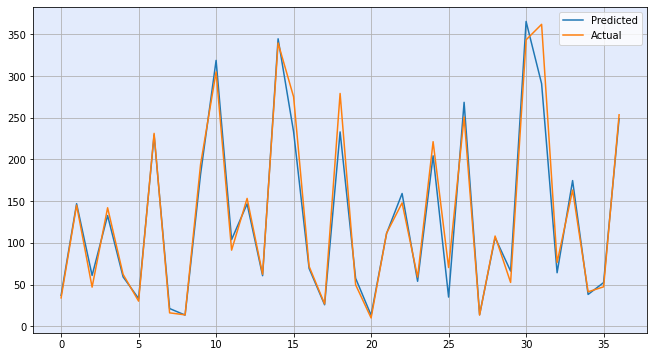

In [125]:
# On Testing data
plt.figure( figsize=(11,6) )
plt.plot(elastic_test, label='Predicted')
plt.plot( y_test, label='Actual')
plt.axes().set_facecolor("#e3ebfc")
plt.grid()
plt.legend()
plt.show()

###<b>Conclusion : We can see that using regulerization accuaracy is less then our models accuracy it means our model is best fit for the data and not prone to overfit.

##<b>Decision Tree Regression Model Building</b>

In [61]:
# Decision Tree Regressor model training without any parameter
tree_regressor = DecisionTreeRegressor()
tree_regressor.fit(x_train, y_train)

DecisionTreeRegressor()

In [62]:
# Decision tree regressor accuracy in trainning data
tree_regressor.score(x_train, y_train)

1.0

In [63]:
# Decision tree regressor accuracy in testing data
tree_regressor.score(x_test, y_test)

0.9799166458716922

###<b>Hyperparameter tuning with GridSearchCV for DecisionTreeRegressor</b>

In [64]:
param_grid = {"criterion": ["mse", "mae"],
              "max_depth": list(np.arange(1,20)),
              "max_leaf_nodes": list(np.arange(1,100,3)),
              "min_samples_leaf": list(np.arange(1,5)),
              "min_samples_split": list(np.arange(1,5))              
              }

In [65]:
# Hyperparameter tuning for Decision Tree Regressor using GridseachCV
dtr = DecisionTreeRegressor()
tree_grid = GridSearchCV(dtr, param_grid, cv=5)

tree_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'max_leaf_nodes': [1, 4, 7, 10, 13, 16, 19, 22, 25, 28,
                                            31, 34, 37, 40, 43, 46, 49, 52, 55,
                                            58, 61, 64, 67, 70, 73, 76, 79, 82,
                                            85, 88, ...],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [1, 2, 3, 4]})

In [66]:
# List of best parameters got from GridSearchCV hyperparameter tuning.
tree_grid.best_params_

{'criterion': 'mse',
 'max_depth': 10,
 'max_leaf_nodes': 85,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [67]:
# Check accuracy score with GridSearchCV
tree_grid.score(x_train, y_train)

0.9999740750064571

###<b>Making Decision Tree Regressor on best parameters</b>

In [68]:
# Decison Tree Regressor model trainning on best parameters got from GridsearchCV hyperparameter tuning.
tree_regressor_best = DecisionTreeRegressor(criterion = 'mse', max_depth = 10, max_leaf_nodes=85, min_samples_leaf = 1, min_samples_split=2) 
tree_regressor_best.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=9, max_leaf_nodes=76)

In [69]:
# Trainning Score on Decision Tree Regressor with best parameters
tree_regressor_best.score(x_train, y_train)

0.9999461617067864

In [70]:
# Testing Score on Decision Tree Regressor with best parameters
tree_regressor_best.score(x_test, y_test)

0.9799897688265878

In [126]:
# Decision tree predicted values for trainning data
tree_train = tree_regressor_best.predict(x_train)

In [127]:
# Decision tree predicted values for testing data
tree_test = tree_regressor_best.predict(x_test)

##<b>Random Forest Regressor Model Building<b>

In [71]:
# Do trainning on random forest regressor without any parameter
random_forest = RandomForestRegressor()
random_forest.fit(x_train, y_train)

RandomForestRegressor()

In [72]:
# Accuracy score of random forest regressor without any parameter 
random_forest.score(x_train, y_train)

0.9979213830177038

In [73]:
# Accuracy score of random forest regressor without any parameter 
random_forest.score(x_test, y_test)

0.9844732591180361

###<b>Hyperparameter tuning with GridSearchCV for Random Forest Regressor</b>

In [74]:
# Hyperparameter tuning for Random Forest Regressor
rfr = RandomForestRegressor()
# grid_values = {'n_estimators':list(np.arange(1,100)), 'max_depth':list(np.arange(1,20))}
param_grid = { 
            "n_estimators"      : np.arange(50,100),
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : np.arange(1,6),
            "bootstrap": [True, False]
            }
# random_forest_gridsearch = GridSearchCV(estimator = dtr, param_grid = grid_values, scoring = 'roc_auc', cv=5)
random_forest_gridsearch = GridSearchCV(rfr, param_grid, n_jobs=-1, cv=5)
random_forest_gridsearch.fit(x_train, y_train)



GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': array([1, 2, 3, 4, 5]),
                         'n_estimators': array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [75]:
# List of best parameters got from GridSearchCV hyperparameter tuning for Random Forest Regressor
random_forest_gridsearch.best_params_

{'bootstrap': True,
 'max_features': 'auto',
 'min_samples_split': 5,
 'n_estimators': 55}

In [76]:
# Random Forest Regressor model trainning on best parameters got from GridsearchCV hyperparameter tuning.
random_forest_best = RandomForestRegressor(bootstrap= True, max_features = 'auto', min_samples_split = 5, n_estimators = 55) 
random_forest_best.fit(x_train, y_train)

RandomForestRegressor(min_samples_split=5, n_estimators=89)

In [77]:
# Trainning Score on Random Forest Regressor with best parameters
random_forest_best.score(x_train, y_train)

0.9972674141680818

In [78]:
# Testing Score on Random Forest Regressor with best parameters
random_forest_best.score(x_test, y_test)

0.9840033706173593

In [128]:
# Random Forest predicted values for trainning data
random_forest_train = random_forest_best.predict(x_train)

In [129]:
# Random Forest predicted values for testing data
random_forest_test = random_forest_best.predict(x_test)

##<b>Gradient Boosting Regressor Model Building</b>

In [79]:
# Do Gradient Boosting regressor without any parameter
gradient_boost = GradientBoostingRegressor()
gradient_boost.fit(x_train, y_train)

GradientBoostingRegressor()

In [80]:
#Gradient Boosting Regressor Mean Absolute Error Of Testing Data On Gradient Boosting Regression
gradBost_MAE_test = mean_absolute_error(y_train, y_pred_train)
print(f"RMSE On Testing Data : {gradBost_MAE_test}")

#Gradient Boosting Mean Squared Error Of Trainning Data
gradBost_MSE_test = mean_squared_error(y_test, y_pred_test)
print(f"MSE On Testing Data : {gradBost_MSE_test}")

#Gradient Boosting Root Mean Squared Error Of Trainning Data
gradBost_RMSE_test = MSE_test**0.5 
print(f"Gradient Boost Root Mean Squared Error On Testing Data : {gradBost_RMSE_test}")

RMSE On Testing Data : 4.020951233984054
MSE On Testing Data : 80.56653535374932
Gradient Boost Root Mean Squared Error On Testing Data : 8.975886326917767


In [81]:
# Accuracy score of random forest regressor without any parameter 
gradient_boost.score(x_train, y_train)

0.999742730226861

In [82]:
# Accuracy score of random forest regressor without any parameter 
gradient_boost.score(x_test, y_test)

0.9829435570230713

##<b>Hyperparameter tuning with GridSearchCV for Gradient Boost Regressor</b>

In [85]:
# Finding best parameters for Gradient Boosting.
GBR = GradientBoostingRegressor()
search_grid = {
              'n_estimators':np.arange(100,600,50),
              'learning_rate':[0.01,1,0.2,0.3],
              'max_depth':np.arange(1,5),
              'subsample':np.arange(0.01,1,0.2),
              'random_state':[0,1]
              }
gbr_grid = GridSearchCV( estimator = GBR, param_grid = search_grid, scoring='neg_mean_squared_error', n_jobs=1, cv=5 )
gbr_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=1,
             param_grid={'learning_rate': [0.01, 1, 0.2, 0.3],
                         'max_depth': array([1, 2, 3, 4]),
                         'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550]),
                         'random_state': [0, 1],
                         'subsample': array([0.01, 0.21, 0.41, 0.61, 0.81])},
             scoring='neg_mean_squared_error')

In [86]:
gbr_grid.best_params_

{'learning_rate': 0.2,
 'max_depth': 2,
 'n_estimators': 150,
 'random_state': 1,
 'subsample': 0.41000000000000003}

In [87]:
# Gradient Boosting Regressor model trainning on best parameters got from GridsearchCV hyperparameter tuning.
gradient_boost_best = GradientBoostingRegressor( learning_rate = 0.2, max_depth = 2, n_estimators = 150, subsample = 0.41) 
gradient_boost_best.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=2, n_estimators=150,
                          subsample=0.41)

In [88]:
# check training score of gradient boost after fit model in best parameters
gradient_boost_best.score(x_train, y_train)

0.9993727929863665

In [89]:
# check training score of gradient boost after fit model in best parameters
gradient_boost_best.score(x_test, y_test)

0.984375096032605

In [130]:
# gradient boost predicted values for training data
gboost_train = gradient_boost_best.predict(x_train)

In [131]:
# gradient boost predicted values for testing data 
gboost_test = gradient_boost_best.predict(x_test)

##<b>Xtream Gradient Boosting (XGBoost) Regressor Model Building



In [92]:
# Do Gradient Boosting regressor without any parameter
xgboost = XGBRegressor()
xgboost.fit(x_train, y_train)

[12:31:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [93]:
# Xtreame gradient boost score in trainning data
xgboost.score(x_train, y_train)

0.9995253876563961

In [94]:
# Xtreame gradient boost score in testinning data
xgboost.score(x_test, y_test)

0.9845404354922205

In [95]:
# Xtream gradient boost predicted values for training data
xgboost_train = xgboost.predict(x_train)

In [96]:
# Xtream gradient boost predicted values for testing data
xgboost_test = xgboost.predict(x_test)

##<b> Comparison Of All Regression Model In Single Plot For Trainning Data<b>

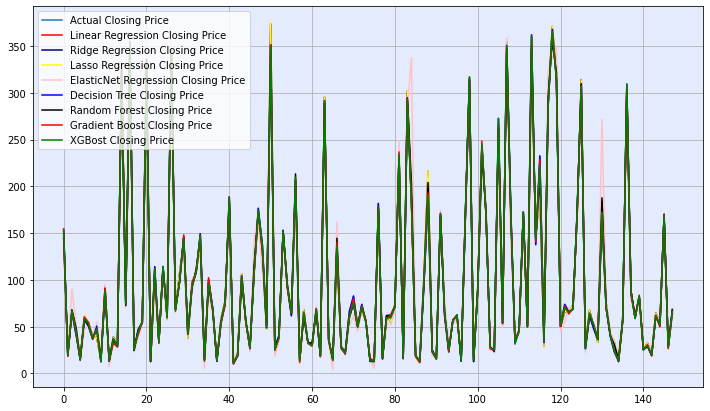

In [151]:
# All ML model closing price On Trainning data
plt.figure( figsize=(12,7) )
plt.plot( y_train, label='Actual Closing Price')
plt.plot(y_pred_train, label='Linear Regression Closing Price', color='red')
plt.plot(ridge_train, label='Ridge Regression Closing Price', color='navy')
plt.plot(lasso_train, label='Lasso Regression Closing Price', color='yellow')
plt.plot(elastic_train, label='ElasticNet Regression Closing Price', color='pink')
plt.plot(tree_train, label='Decision Tree Closing Price', color='blue')
plt.plot(random_forest_train, label='Random Forest Closing Price', color='black')
plt.plot(gboost_train, label='Gradient Boost Closing Price', color='red')
plt.plot(xgboost_train, label='XGBost Closing Price', color='green')
plt.axes().set_facecolor("#e3ebfc")
plt.grid()
plt.legend()
plt.show()

##<b>Comparison Of All Regression Model In Single Plot For Testing Data</b>

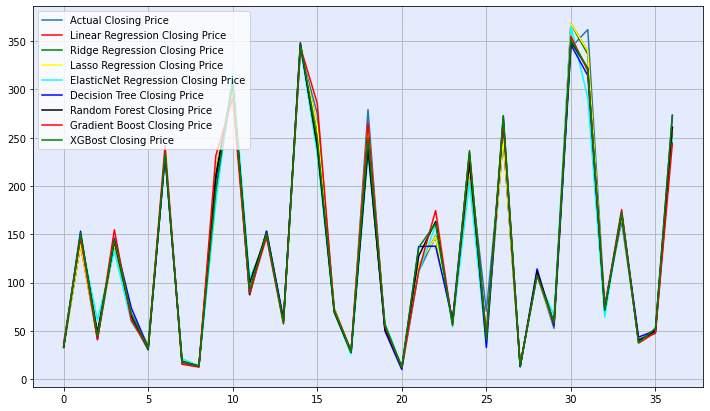

In [135]:
# All ML model closing price On Testing data
plt.figure( figsize=(12,7) )
plt.plot( y_test, label='Actual Closing Price')
plt.plot(y_pred_test, label='Linear Regression Closing Price', color='red')
plt.plot(ridge_test, label='Ridge Regression Closing Price', color='green')
plt.plot(lasso_test, label='Lasso Regression Closing Price', color='yellow')
plt.plot(elastic_test, label='ElasticNet Regression Closing Price', color='cyan')
plt.plot(tree_test, label='Decision Tree Closing Price', color='blue')
plt.plot(random_forest_test, label='Random Forest Closing Price', color='black')
plt.plot(gboost_test, label='Gradient Boost Closing Price', color='red')
plt.plot(xgboost_test, label='XGBost Closing Price', color='green')
plt.axes().set_facecolor("#e3ebfc")
plt.grid()
plt.legend()
plt.show()

# <b>Summary Of All Machine Learning Regression Model<b>

In [141]:
# Name of all regression model and their object name in list of tuple format
regression_model = [
  ('Linear Regression : ', regressor),
  ('Ridge : ', ridge_with_best_alpha),
  ('Lasso : ', lasso_with_best_alpha),
  ('Elastic Net', elastic_reg_best),
  ('DecisionTreeRegressor : ', tree_regressor),
  ('RandomForestRegressor : ', random_forest),
  ('GradientBoostingRegressor : ', gradient_boost),
  ('XGBRegressor : ', xgboost)
]

In [143]:
# Making List Of All Machine Learing Model Scores
regression_model_model_scores = []
for name,current_model in regression_model:
  curr_model_data={}
  current_model.random_state=1
  curr_model_data['Name']=name
  if(name!='LinearRegression: '):
    current_model.fit(x_train,y_train)
    curr_model_data['MAE']=mean_absolute_error(y_test,current_model.predict(x_test))
    curr_model_data['MSE']=mean_squared_error(y_test,current_model.predict (x_test))
    curr_model_data['RMSE']=np.sqrt(mean_squared_error(y_test, current_model.predict(x_test)))
    curr_model_data['R2_Train']=r2_score(y_train,current_model.predict (x_train))
    curr_model_data['R2_Test']=r2_score(y_test,current_model.predict (x_test))
    
    # adjusted R-squared
    Adj_R2_Train = 1 - ( ( 1- current_model.score(x_train, y_train) ) * ( len(y_train) - 1 ) / ( len(y_train) - x_train.shape[1] - 1 ) )
    Adj_R2_Test = 1 - ( ( 1- current_model.score(x_test, y_test) ) * ( len(y_test) - 1 ) / ( len(y_test) - x_test.shape[1] - 1 ) )

    curr_model_data['Adj_R2_Train'] = Adj_R2_Train
    curr_model_data['Adj_R2_Test'] = Adj_R2_Test
    regression_model_model_scores.append(curr_model_data)


[12:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [144]:
# Create data frame of all ml model scores.
ml_model_score_df = pd.DataFrame(regression_model_model_scores)
ml_model_score_df

,Name,MAE,MSE,RMSE,R2_Train,R2_Test,Adj_R2_Train,Adj_R2_Test
0,Linear Regression :,5.710385,80.566535,8.975886,0.995647,0.992842,0.995493,0.991688
1,Ridge :,5.774960,85.835491,9.264745,0.995579,0.992374,0.995424,0.991144
2,Lasso :,5.710385,80.566545,8.975887,0.995647,0.992842,0.995493,0.991688
3,Elastic Net,11.570182,349.676531,18.699640,0.954311,0.968934,0.952702,0.963923
4,DecisionTreeRegressor :,10.038378,265.494859,16.294013,1.000000,0.976413,1.000000,0.972608
5,RandomForestRegressor :,8.008092,168.490601,12.980393,0.998189,0.985031,0.998125,0.982617
6,GradientBoostingRegressor :,9.066013,187.158492,13.680588,0.999743,0.983372,0.999734,0.980691
7,XGBRegressor :,8.602679,174.011351,13.191336,0.999525,0.984540,0.999509,0.982047


#<b>Conclusion:- </b>
### 1.Target Variable is strongly dependent on Independent Variables.
### 2.We have seen that in our yes bank dataset theire is no null values and no duplicate values are present. In this dataset we have one feature name is 'Date' which is  object type, so we need to convert this into date formate and apply some feature engineering methods.

### 4.With the help of distribution plot ,We see that our data is positively skewed.So,We apply some kind of transformation i.e. Log Transformation to convert it into a normal distribution.

### 5. Lasso and Ridge regression models are giving the same result approximately.

### 6. We have implemented Cross Validation on different algorithm as CV performs better on small datasets.But, the result is nearly same.

